In [3]:
import math
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

**S**
* t=1/2-Pr[f]=Pr[m]-1/2

**S=f**
* U: $B(0.2)$, Pr[a|f]=0.2
* X|U=a: $N(-10,25)$
* X|U=b: $N(-12,25)$

**S=m**
* U: $B(0.8)$, Pr[a|m]=0.8
* X|U=a: $N(12,1)$
* X|U=b: $N(10,1)$

In [38]:
keys = ['t','a_f', 'a_m','b_f', 'b_m']
values = [0.2,0.2,0.8,0.8,0.2]
para = dict(zip(keys, values))

para['X_af_mean']=-10
para['X_af_sd']=5
para['X_bf_mean']=-12
para['X_bf_sd']=5

para['X_am_mean']=12
para['X_am_sd']=1
para['X_bm_mean']=10
para['X_bm_sd']=1

In [78]:
para['f']=1/2-para['t']
para['m']=1/2+para['t']
para['a']=para['a_f']*para['f']+para['a_m']*para['m']
para['b']=para['b_f']*para['f']+para['b_m']*para['m']
para['f_a']=inverse_probability('f_a',para)
para['m_a']=inverse_probability('m_a',para)
para['f_b']=inverse_probability('f_b',para)
para['m_b']=inverse_probability('m_b',para)

In [42]:
def inverse_probability(name,para):
    return para[name[::-1]]*para[name[0]]/para[name[-1]]
def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))


In [83]:
horizen=[-50,50]
width=0.1
bin=int((horizen[1]-horizen[0])/width)
x_range=np.arange(horizen[0],horizen[1],width)

dist = dict(zip(['horizen','width','bin','x_range'], [horizen,width,bin,x_range]))

In [84]:
dist['x_af']=[Gaussian_pdf(x,'X_af',para)*width for x in x_range]
dist['x_am']=[Gaussian_pdf(x,'X_am',para)*width for x in x_range]
dist['x_bf']=[Gaussian_pdf(x,'X_bf',para)*width for x in x_range]
dist['x_bm']=[Gaussian_pdf(x,'X_bm',para)*width for x in x_range]
dist['x_a']=[dist['x_af'][i]*para['a_f']+dist['x_am'][i]*para['a_m'] for i in range(bin)]
dist['x_b']=[dist['x_bf'][i]*para['b_f']+dist['x_bm'][i]*para['b_m'] for i in range(bin)]


In [85]:
inverse=dict(zip(['f','m','a','b'],['m','f','b','a']))

In [86]:
def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]

In [114]:
def second_moment(name,para):
    return para[name+'_mean']**2+para[name+'_sd']**2

In [123]:
def c_generate(n,m):
    C=np.random.random((n, m))
    for i in range(n):
        for j in range(n):
            C[i,j]=abs(i-j)
    return C

def algorithms(reg,m,n,g,f,C):
    K=np.exp(-C/C.max()/reg)
    interations=10000
    u=np.ones((n,1))
    for i in range(1,interations):
        v=g/np.dot(K.T,u)
        u=f/np.dot(K,v)
    return np.dot(np.diag(u.reshape((1,-1))[0]),np.dot(K,np.diag(v.reshape((1,-1))[0])))

def assess(m,n,g,f,C,output):
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f.reshape(n))))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g.reshape(m))))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('============================================')
    
def plots(m,n,g,f,output):
    fig = plt.figure(figsize=(4, 3))

    gs = fig.add_gridspec(2, 2, width_ratios=(bin, 1), height_ratios=(1, bin),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.pcolormesh(range(m), range(n), output, cmap='Blues')
    ax_histx.plot(range(m),g)
    ax_histy.plot(f,range(n)) 

In [115]:
para['X_a_t_mean']=para['X_af_mean']*para['f_a']+para['X_am_mean']*para['m_a']
para['X_a_t_sd']=math.sqrt(second_moment('X_af',para)*para['f_a']+second_moment('X_am',para)*para['m_a']-para['X_a_t_mean']**2)

In [106]:
dist['x_a_t']=[Gaussian_pdf(x,'X_a_t',para)*width for x in x_range]

In [126]:
dist['x_a_e']=normialise([dist['x_af'][i]**para['f_a']*dist['x_am'][i]**para['m_a'] for i in range(bin)])  
dist['x_b_e']=normialise([dist['x_bf'][i]**para['f_b']*dist['x_bm'][i]**para['m_b'] for i in range(bin)]) 

reg: 0.01
top:x_a
right:x_a_target
sum of violation of f: 1.2489301067286307e-16
sum of violation of g: 1.4632915954095252e-14
total cost: 47.82075405769424
entropy: 6.437227211339468


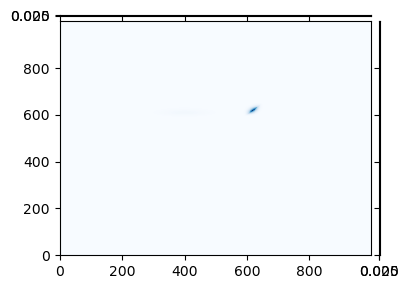

In [130]:
reg=0.01 #10**(1-2)
print('reg:',reg)
print('top:x_a')
print('right:x_a_target')
C=c_generate(bin,bin)
mu=np.array(dist['x_a'])
mu_t=np.array(dist['x_a_e'])
output=algorithms(reg,bin,bin,mu.reshape(bin,-1),mu_t.reshape(bin,-1),C)
assess(bin,bin,mu,mu_t,C,output)
plots(bin,bin,mu,mu_t,output)

reg: 0.01
top:x_b
right:x_b_target
sum of violation of f: 1.4382677739550665e-16
sum of violation of g: 2.4627157591736504e-14
total cost: 163.1184828186573
entropy: 6.80622444500094


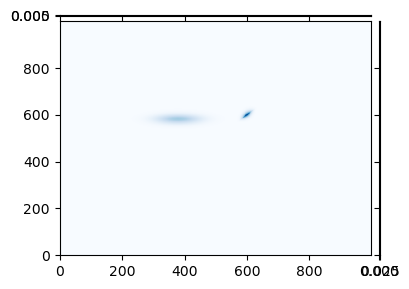

In [129]:
reg=0.01 #10**(1-2)
print('reg:',reg)
print('top:x_b')
print('right:x_b_target')
C=c_generate(bin,bin)
mu=np.array(dist['x_b'])
mu_t=np.array(dist['x_b_e'])
output=algorithms(reg,bin,bin,mu.reshape(bin,-1),mu_t.reshape(bin,-1),C)
assess(bin,bin,mu,mu_t,C,output)
plots(bin,bin,mu,mu_t,output)

In [ ]:
num=1000


In [ ]:
bin=5
width=1
num=100
t=0.2
data=pd.DataFrame(columns=['X', 'I', 'J'], index=[*range(num)])
for i in range((int(num*(0.5-t)))):
    data.loc[i]=[int(random.gauss(1,1)/width),random.random(),'f']
for j in range(i+1,num):
    data.loc[j]=[int(random.gauss(4,0.5)/width),random.random(),'m']
a=(data[data['J']=='f']['I']>=0.8).tolist()
b=(data[data['J']=='m']['I']>=0.2).tolist()
data.loc[a+b,'I']='b'
data.loc[data['I']!='b','I']='a'
data['W']=1
if (max(data['X'])<bin) & (min(data['X'])>=0):
    print('ok')
else:
    data=data[(data['X']<bin) & (data['X']>=0)]
mu=distribution(data)
mu_a=distribution(data[data['I']=='a'])
mu_b=distribution(data[data['I']=='b'])
mu_f=distribution(data[data['J']=='f'])
mu_m=distribution(data[data['J']=='m'])
print('original',mu)
print('mu_a',mu_a)
print('mu_b',mu_b)
print('mu_f',mu_f)
print('mu_m',mu_m)
$T: X\to\hat{X}$
mu_t=np.array([0]*(bin-1)+[1])
reg=0.1 #10**(1-2)
print('reg:',reg)
C=c_generate(bin,bin)
output=algorithms(reg,bin,bin,mu.reshape(bin,-1),mu_t.reshape(bin,-1),C)
assess(bin,bin,mu,mu_t,C,output)
plots(bin,bin,mu,mu_t,output)
print('up:',sum(output))
print('right:',sum(output.T))
print(np.flipud(output))
data_revised=projection(data,output)
print(mu_t)
print(distribution(data_revised))
**Evaluation of $T$**
mu_a_r=distribution(data_revised[data_revised['I']=='a'])
mu_b_r=distribution(data_revised[data_revised['I']=='b'])
mu_f_r=distribution(data_revised[data_revised['J']=='f'])
mu_m_r=distribution(data_revised[data_revised['J']=='m'])
evaluation_plot()
$T_i$
mu_a=distribution(data[(data['I']=='a')])
mu_b=distribution(data[(data['I']=='b')])
mu_af=distribution(data[(data['I']=='a')&(data['J']=='f')])
mu_am=distribution(data[(data['I']=='a')&(data['J']=='m')])
mu_bf=distribution(data[(data['I']=='b')&(data['J']=='f')])
mu_bm=distribution(data[(data['I']=='b')&(data['J']=='m')])
mu_a_t=(mu_af**s_a[0])*(mu_am**s_a[1])/sum((mu_af**s_a[0])*(mu_am**s_a[1]))
mu_b_t=(mu_bf**s_b[0])*(mu_bm**s_b[1])/sum((mu_bf**s_b[0])*(mu_am**s_b[1]))
s_a=[sum(data[(data['I']=='a')&(data['J']==k)]['W'])/sum(data[(data['I']=='a')]['W']) for k in ['f','m']]
s_b=[sum(data[(data['I']=='b')&(data['J']==k)]['W'])/sum(data[(data['I']=='b')]['W']) for k in ['f','m']]
mu_a_t
mu_b_t
reg=0.01 #10**(1-2)
print('reg:',reg)
print('top:',mu_a)
print('right:',mu_a_t)
C=c_generate(bin,bin)
output_a=algorithms(reg,bin,bin,mu_a.reshape(bin,-1),mu_a_t.reshape(bin,-1),C)
print(sum(output_a))
print(sum(output_a.T))
assess(bin,bin,mu_a,mu_a_t,C,output_a)
plots(bin,bin,mu_a,mu_a_t,output_a)
reg=0.01 #10**(1-2)
print('reg:',reg)
print('top:',mu_b)
print('right:',mu_b_t)
C=c_generate(bin,bin)
output_b=algorithms(reg,bin,bin,mu_b.reshape(bin,-1),mu_b_t.reshape(bin,-1),C)
print(sum(output_b))
print(sum(output_b.T))
assess(bin,bin,mu_b,mu_b_t,C,output_b)
plots(bin,bin,mu_b,mu_b_t,output_b)
data_revised_a=projection(data[data['I']=='a'],output_a)
data_revised_b=projection(data[data['I']=='b'],output_b)
data_revised_i=pd.concat([data_revised_a,data_revised_b],ignore_index=True)
**Evaluation of $T_i$**
mu_af_r=distribution(data_revised_i[(data_revised_i['I']=='a')&(data_revised_i['J']=='f')])
mu_am_r=distribution(data_revised_i[(data_revised_i['I']=='a')&(data_revised_i['J']=='m')])
mu_a_r=distribution(data_revised_i[data_revised_i['I']=='a'])
color=['r','y','b','g']
plt.plot([*range(bin)],mu_af_r,'-',label='mu_af_result',color=color[0])
plt.plot([*range(bin)],mu_am_r,'-',label='mu_am_result',color=color[1])
#plt.plot([*range(bin)],mu_a_r,'-',label='mu_a_r',color=color[3])
plt.plot([*range(bin)],mu_af,'--',label='mu_af',color=color[0])
plt.plot([*range(bin)],mu_am,'--',label='mu_am',color=color[1])
plt.legend()

print(distance(mu_af_r,mu_am_r))
print(distance(mu_af,mu_am))
mu_bf_r=distribution(data_revised_i[(data_revised_i['I']=='b')&(data_revised_i['J']=='f')])
mu_bm_r=distribution(data_revised_i[(data_revised_i['I']=='b')&(data_revised_i['J']=='m')])
color=['r','y','b','g']
plt.plot([*range(bin)],mu_bf_r,'-',label='mu_bf_result',color=color[0])
plt.plot([*range(bin)],mu_bm_r,'-',label='mu_bm_result',color=color[1])
plt.plot([*range(bin)],mu_bf,'--',label='mu_bf',color=color[0])
plt.plot([*range(bin)],mu_bm,'--',label='mu_bm',color=color[1])
plt.legend()

print(distance(mu_bf_r,mu_bm_r))
print(distance(mu_bf,mu_bm))
**Verification of Lemma 4.3-4.4**

output_a[0,:] = mu_a_t[0]
output_a[:,0] = mu_a[0]
output_a[j,i]: mu_a[i] to mu_a_t[j]: Pr[x=i,tx=j|a]
output_fa=np.zeros([bin,bin])
output_ma=np.zeros([bin,bin])
for j in range(bin):
    for i in range(bin):
        if sum(data[(data['X']==i)&(data['I']=='a')]['W']) > 0:
            s_xu=[sum(data[(data['X']==i)&(data['I']=='a')&(data['J']==k)]['W'])/sum(data[(data['X']==i)&(data['I']=='a')]['W']) for k in ['f','m']]
        else: 
            s_xu=[0,0]
        output_fa[j,i]=output_a[j,i]*s_xu[0]
        output_ma[j,i]=output_a[j,i]*s_xu[1]
guess1=projection(data[(data['I']=='a')&(data['J']=='f')],output_fa/sum(sum(output_fa)) )
guess2=projection(data[(data['I']=='a')&(data['J']=='m')],output_ma/sum(sum(output_ma)) )
guess_a=pd.concat([guess1,guess2],ignore_index=True)
mu_af_e=np.zeros([bin])
mu_am_e=np.zeros([bin])
for j in range(bin):
    s_u=[sum(data[(data['I']=='a')&(data['J']==j)]['W'])/sum(data[(data['I']=='a')]['W']) for j in ['f','m']]
    mu_af_e[j]=sum(output_fa[j,:])/s_u[0]
    mu_am_e[j]=sum(output_ma[j,:])/s_u[1]
print(mu_af_e) #/sum(mu_af_e)
mu_af_r=distribution(data_revised_i[(data_revised_i['I']=='a')&(data_revised_i['J']=='f')])
print(mu_af_r)
**Functions**

def relative_entropy(p,q):
    ent=0
    for i in range(len(p)):
        if (p[i]==0)|(q[i]==0):
            continue
        ent+=p[i]*math.log(p[i]/q[i])
    return ent
def distance(p,q):
    ent=0
    for i in range(len(p)):
        ent+=abs(p[i]-q[i])
    return ent

def evaluation_plot():
    color=['r','y','b','g']
    fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(6,2))
    fig.subplots_adjust(wspace=0.2, hspace=0.1)

    axs[0].plot([*range(bin)],mu_f,'-',label='mu_f',color=color[0])
    axs[0].plot([*range(bin)],mu_f_r,'--',label='mu_f_r',color=color[0])
    axs[0].plot([*range(bin)],mu_m,'-',label='mu_m',color=color[1])
    axs[0].plot([*range(bin)],mu_m_r,'--',label='mu_m_r',color=color[1])
    axs[0].set_title('x|f & x|m')

    axs[1].plot([*range(bin)],mu_a,'-',label='mu_a',color=color[2])
    axs[1].plot([*range(bin)],mu_a_r,'--',label='mu_a_r',color=color[2])
    axs[1].plot([*range(bin)],mu_b,'-',label='mu_b',color=color[3])
    axs[1].plot([*range(bin)],mu_b_r,'--',label='mu_b_r',color=color[3])
    axs[1].set_title('x|a & x|b')

    print('sum |X|f-X|m|=',sum(abs(mu_f-mu_m)))
    print('sum |Xhat|f-Xhat|m|=',sum(abs(mu_f_r-mu_m_r)))

    print('sum D(x|a)=',sum(abs(mu_a-mu_a_r)))
    print('sum D(x|b)=',sum(abs(mu_b-mu_b_r)))
    axs[0].legend()
    axs[1].legend()

def projection(df,coupling):
    df_t=pd.DataFrame(columns=['X', 'I', 'J','W'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        sub=pd.DataFrame(columns=['X','W'],index=[*range(bin)])
        sub['X']=[*range(bin)]
        sub['W']=coupling[:,orig[0]]/(sum(coupling[:,orig[0]])+0.0001)*orig[3]
        sub['I']=orig[1]
        sub['J']=orig[2]
        df_t=pd.concat([df_t, sub], ignore_index=True)
    return df_t

def distribution(sub):
    dist=np.zeros(bin)
    for i in range(bin):
        dist[i]=sum(sub[sub['X']==i]['W'])
    if sum(dist)>0:
        return dist/sum(dist)
    else:
        return dist

# def distribution(sub):
#     bin=10
#     width=3/(bin)
#     ranges=np.arange(0,3+width,width)
#     dist=np.zeros(bin)
#     for i in range(bin-1):
#         dist[i]=sum(sub[(sub['X']>=ranges[i])&(sub['X']<ranges[i+1])]['W'])
#     return dist/sum(dist)

def c_generate(n,m):
    C=np.random.random((n, m))
    for i in range(n):
        for j in range(n):
            C[i,j]=abs(i-j)
    return C

def algorithms(reg,m,n,g,f,C):
    K=np.exp(-C/C.max()/reg)
    interations=10000
    u=np.ones((n,1))
    for i in range(1,interations):
        v=g/np.dot(K.T,u)
        u=f/np.dot(K,v)
    return np.dot(np.diag(u.reshape((1,-1))[0]),np.dot(K,np.diag(v.reshape((1,-1))[0])))

def assess(m,n,g,f,C,output):
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f.reshape(n))))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g.reshape(m))))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('============================================')
    
def plots(m,n,g,f,output):
    fig = plt.figure(figsize=(4, 3))

    gs = fig.add_gridspec(2, 2, width_ratios=(bin, 1), height_ratios=(1, bin),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    c=ax.pcolormesh(range(m), range(n), output, cmap='Blues')
    ax_histx.plot(range(m),g)
    ax_histy.plot(f,range(n)) 